In [40]:
import numpy as np
import control.matlab as control
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.animation as animation
from IPython.display import HTML

## Redefine model

In [41]:
class PoolingModel(nn.Module):
    
    def __init__(self, feature_size, hidden_size, action_dim):
        
        super(PoolingModel, self).__init__()
        
        # dimensionality of state features
        self.feature_size = feature_size
        
        # hidden layer dimensionalities
        self.hidden_size = hidden_size
        
        # dimensionality of action space
        self.action_dim = action_dim
        
        # encodes state-action pairs into feature vectors
        self.encoder1 = nn.Sequential(
            nn.Linear(self.feature_size, self.hidden_size),
            nn.Softplus(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Softplus(),
            nn.Linear(self.hidden_size, self.hidden_size),
        )

        
        # mean pooling over trajectory features
        self.pooling_layer = lambda x: x.sum(dim=-2)
        
        self.running_pooling_layer = lambda x: x.cumsum(dim=-2)
        
        self.max_seq_len = 5000
        
        self.division_mask = torch.tensor(range(1, self.max_seq_len + 1), dtype=torch.float32).reshape(1, -1, 1)
        
        # maps pooled representations to trajectory features
        self.encoder2 = nn.Sequential(
            nn.Linear(self.hidden_size + 9, self.hidden_size),
            nn.Softplus(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Softplus()
        )
        
        self.mu = nn.Linear(self.hidden_size, action_dim)
        
        self.log_sigma = nn.Linear(self.hidden_size, action_dim)

    
    def forward(self, input_traj, delta_t=0.01253533):
        
        # generate predictions for each time step
        batch_size, time_steps, state_size = input_traj.shape
        
        # forward pass
        outputs = self.encoder1(input_traj)
        
        # mean pooling
        outputs = self.running_pooling_layer(outputs)
        
        division_mask = self.division_mask[:, :outputs.shape[-2], :]
        outputs = outputs / division_mask
        
        velocities = input_traj[:, 1:, :] - input_traj[:, :-1, :]
        input_vels = torch.cat([torch.zeros_like(velocities[:, :1, :]), velocities], dim=1)
        input_vels = input_vels * 5
        
        # estimate acceleration
        accelerations = input_vels[:, 1:, :] - input_vels[:, :-1, :]
        input_accs = torch.cat([torch.zeros_like(accelerations[:, :1, :]), accelerations], dim=1)
        
        # estimate jerk
        jerks = input_accs[:, 1:, :] - input_accs[:, :-1, :]
        input_jerks = torch.cat([torch.zeros_like(jerks[:, :1, :]), jerks], dim=1)
        
        normalised_time = torch.linspace(0, 5, time_steps).unsqueeze(0).unsqueeze(-1).repeat(batch_size, 1, 1)
        
        enc2_inputs = torch.cat([outputs, input_traj, input_vels, input_accs, input_jerks, normalised_time], dim=-1)
        outputs = self.encoder2(enc2_inputs)
        vel_preds = self.mu(outputs)
        next_state_preds = input_traj[:, :-1, :] + delta_t * vel_preds[:, :-1, :]
        
        return next_state_preds

## Load data

In [42]:
mat = scipy.io.loadmat('Demo_Drawing_Drawing.mat')
(mat['s_seg_intp']['DataP'])[0][0].shape

data = np.concatenate((mat['s_seg_intp']['DataP'])[0, :], axis=0).reshape(5, 10, 400)

pos_data = data[:, 1:3, :].swapaxes(1,2)
vel_data = data[:, 4:6, :].swapaxes(1,2)

In [43]:
# construct scale factors
scale_factors = np.reshape([0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4], (-1, 1, 1, 1))
dummy_scale_factors = np.reshape([1.0] * 8, (-1, 1, 1, 1))

In [44]:
aug_pos_data = np.reshape(pos_data * scale_factors, (-1, pos_data.shape[-2], pos_data.shape[-1]))
aug_vel_data = np.reshape(vel_data * scale_factors, (-1, pos_data.shape[-2], pos_data.shape[-1]))

scaling = 100
aug_pos_data = aug_pos_data * scaling
aug_vel_data = aug_vel_data * scaling

# Center the coordinate system at the initial state
aug_pos_data_centered = aug_pos_data - aug_pos_data[:, :1, :]

## Load model

In [45]:
model = PoolingModel(feature_size=2, hidden_size=32, action_dim=2)
load_path = "./pooling_model_v2_weights.pth"
model.load_state_dict(torch.load(load_path))

/tmp/ipykernel_74990/1119137686.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


<All keys matched successfully>

## Evaluate scale adaptation offline

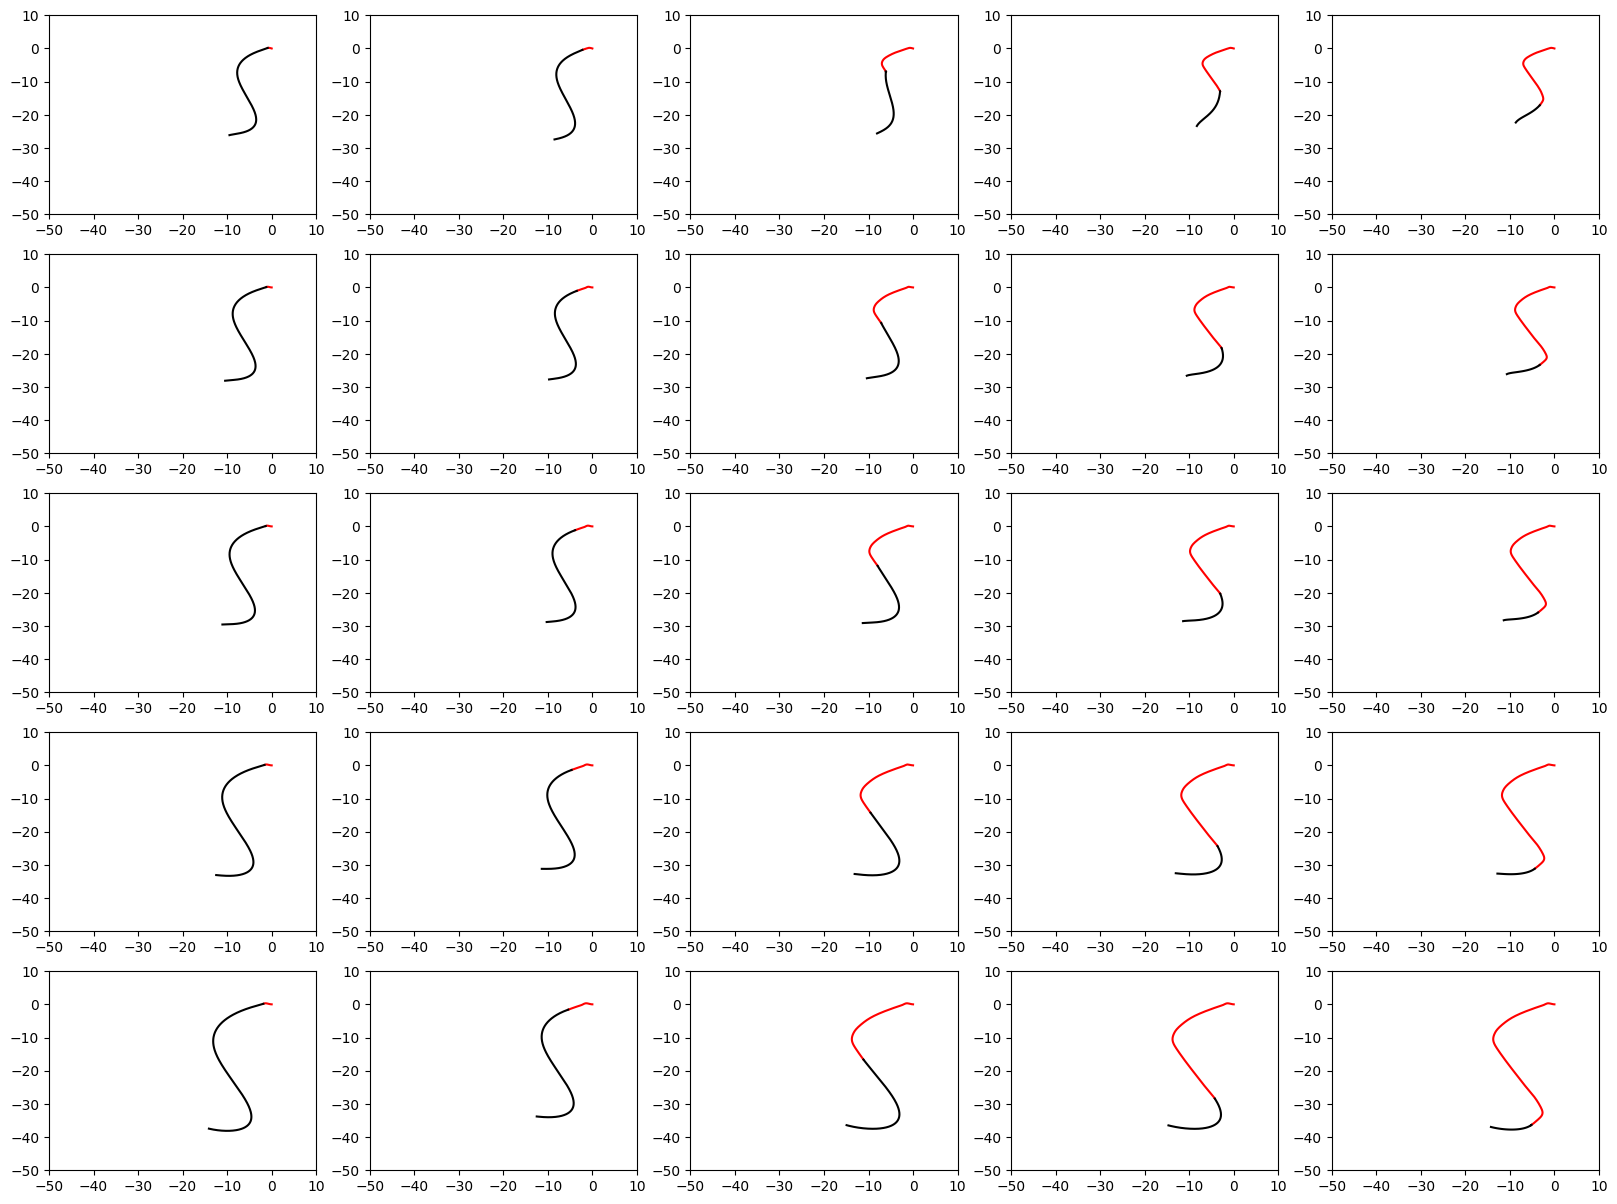

In [46]:
# Plot scale adaptation

# approximate sampling interval in custom dataset
delta_t = 0.01253533

cond_lengths = [50, 100, 200, 250, 300]
data_indices = [4, 10, 15, 25, 35]    # each element indicates a trajectory
c = 1
plt.figure(figsize=(20,15))
for data_index in data_indices:
    for conditioning_length in cond_lengths:
        time_steps = 400 
        states = np.zeros((time_steps, 2))
        traj_start = aug_pos_data_centered[data_index, :conditioning_length+1, :].copy()
        state = aug_pos_data_centered[data_index, conditioning_length, :].copy()
        states[:conditioning_length+1, :] = traj_start

        for i in range(conditioning_length, time_steps - 1):
            inputs = torch.tensor(states, dtype=torch.float32)
            mu_preds = model.forward(torch.unsqueeze(inputs, 0), delta_t=delta_t).squeeze()
            mu_preds_array = mu_preds[i, :].detach().numpy()
            state = mu_preds_array
            if i < time_steps-1:
                states[i+1, :] = state
        
        plt.subplot(5,5,c)
        plt.xlim(-50, 10)
        plt.ylim(-50, 10)
        plt.plot(states[:conditioning_length, 0], states[:conditioning_length, 1], label="model conditioning", c="red")
        plt.plot(states[conditioning_length-1:, 0], states[conditioning_length-1:, 1], label="prediction from initial state", c="black")
        c += 1

## Evaluate in Pybullet

In [47]:
import pybullet as p
import pybullet_data
import time

# Start the physics client
p.connect(p.GUI)

# Set up PyBullet data path
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Load environment
p.loadURDF("plane.urdf")
robot = p.loadURDF("franka_panda/panda.urdf", useFixedBase=True)

# Set simulation time step for 80 Hz (1/80 seconds)
time_step = 1 / 800
delta_t = 0.01253533
p.setTimeStep(time_step)

# Helper function to get current end-effector position
def get_end_effector_position(robot):
    ee_index = 11  # Panda's end-effector joint index
    state = p.getLinkState(robot, ee_index)
    position = np.array(state[0])  # End-effector position
    return position[:2]  # Only x, y

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=nouveau
GL_RENDERER=NV166
GL_VERSION=4.3 (Core Profile) Mesa 21.2.6
GL_SHADING_LANGUAGE_VERSION=4.30
pthread_getconcurrency()=0
Version = 4.3 (Core Profile) Mesa 21.2.6
Vendor = nouveau
Renderer = NV166
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = nouveau
ven = nouveau


In [48]:
# Record the initial position of the end-effector for normalization
initial_position = get_end_effector_position(robot)

time_steps = 600
states = np.zeros((time_steps, 2))

state = np.zeros((2), dtype=np.float32)
states[0, :] = state

# Initialize simulation variables
actual_trajectory = []  # Store actual trajectory
planned_trajectory = []  # Store planned trajectory

for i in range(time_steps-1):
    
    # Load data history into tensor
    inputs = torch.tensor(states, dtype=torch.float32)
    
    # Predict next state
    mu_preds = model.forward(torch.unsqueeze(inputs, 0), delta_t=delta_t).squeeze()
    
    # Convert to numpy
    mu_preds_array = mu_preds[i, :].detach().numpy()
    
    # Transform to robot's domain
    next_target = mu_preds_array / 100 + initial_position
    
    planned_trajectory.append(next_target)
    
    for _ in range(10):
        
        # Use inverse kinematics to compute joint positions for the target end-effector position
        joint_positions = p.calculateInverseKinematics(
            bodyIndex=robot,
            endEffectorLinkIndex=11,  # End-effector joint index
            targetPosition=[next_target[0], next_target[1], 0.821]  # Target x, y, z
        )

        # Apply the calculated joint positions to control the robot
        for joint_index in range(len(joint_positions)):
            p.setJointMotorControl2(
                bodyIndex=robot,
                jointIndex=joint_index,
                controlMode=p.POSITION_CONTROL,
                targetPosition=joint_positions[joint_index]
            )

        # Step the simulation
        p.stepSimulation()

    # Record actual trajectory and update history with normalized values
    current_position = get_end_effector_position(robot)
    
    actual_trajectory.append(current_position)
    states[i+1, :] = (current_position - initial_position) * 100

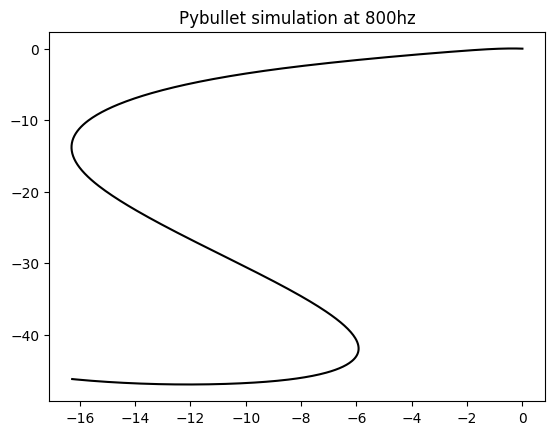

In [49]:
# Plot the generated trajectory

plt.plot(states[:, 0], states[:, 1], c='black')
plt.title("Pybullet simulation at 800hz")
plt.show()

In [50]:
# Run this cell to disconnect from server
p.disconnect()

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
destroy semaphore
semaphore destroyed
Thread TERMINATED
destroy main semaphore
main semaphore destroyed
